# CYBERML Project

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC, OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, average_precision_score, balanced_accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
import sklearn.neighbors
import shap

DATA_FOLDER = './data/'
ATTACK_FOLDER = 'attack_data/'
BENIGN_FOLDER = 'benign_data/'

/home/baptiste/cyberml/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Metrics

In [2]:
def print_metrics(y_true, y_pred, labels=None, target_names=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    report = classification_report(y_true, y_pred, labels=labels, target_names=target_names)
    mcc = matthews_corrcoef(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    
    print(f"Confusion matrix:\n{cm}")
    print(f"Classification report:\n{report}")
    print(f"Matthews Corrcoef: {mcc:.4f}")
    if labels is None:
         try:
            ap = average_precision_score(y_true, y_pred)
            print(f"Average precision: {ap:.4f}")
         except ValueError:
            pass
    print(f"Balanced accuracy: {bal:.4f}")

## SHAP (feature importance plot)

In [3]:
def plot_shap(model, X_train):
    if len(X_train) > 2000:
        X_sample = X_train.sample(2000, random_state=42)
    else:
        X_sample = X_train

    explainer = shap.TreeExplainer(model)
    explanation = explainer(X_sample)

    if len(explanation.values.shape) > 2:
        print("Multiclass detected: Plotting SHAP beeswarm for Class 0.")
        shap.plots.beeswarm(explanation[:,:,0])
    else:
        shap.plots.beeswarm(explanation)

    print("\n=== Feature Importance (Mean Absolute SHAP) ===")
    
    global_shap_values = np.abs(explanation.values).mean(axis=0)
    
    if global_shap_values.ndim > 1:
        global_shap_values = global_shap_values.mean(axis=1)
        
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': global_shap_values
    })
    
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    print(feature_importance.head(n=10))

## Load and merge

In [4]:
def load_and_merge_data(duration_sec):
    print(f"\n\nProcessing duration: {duration_sec} seconds")
    attack_file = f"attack_samples_{duration_sec}sec.csv"
    benign_file = f"benign_samples_{duration_sec}sec.csv"
    
    attack_data = pd.read_csv(DATA_FOLDER + ATTACK_FOLDER + attack_file)
    benign_data = pd.read_csv(DATA_FOLDER + BENIGN_FOLDER + benign_file)
    
    print("Attack Data Shape:", attack_data.shape)
    print("Benign Data Shape:", benign_data.shape)

    combined_data = pd.concat([attack_data, benign_data], ignore_index=True)
    combined_data = combined_data.sample(frac=1).reset_index(drop=True)
    print("Combined Data Shape:", combined_data.shape)
    return combined_data

## Process and split

In [5]:
def preprocess_data(combined_data):
    combined_data.fillna(0, inplace=True)

    encoded_data = combined_data.copy()

    encoded_values = {}

    label_columns = ['label1', 'label2', 'label3', 'label4']
    for col in label_columns:
        encoded_data[col], uniques = pd.factorize(encoded_data[col])
        encoded_values[col] = dict(enumerate(uniques))

    encoded_data = encoded_data.select_dtypes(include=[np.number])
    
    X = encoded_data.drop(['label1', 'label2', 'label3', 'label4'], axis=1)
    y = encoded_data['label1']
    y_type = encoded_data['label2']
    
    X_train, X_test, y_train, y_test, y_type_train, y_type_test = train_test_split(
        X, y, y_type, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, y_type_train, y_type_test, encoded_values


## Supervised learning

In [6]:
def run_supervised_learning(X_train, X_test, y_train, y_test):
    print("## Supervised Learning")

    print("### Train With Gradient Boosting")
    modelGboost = xgboost.XGBClassifier()
    modelGboost.fit(X_train, y_train)
    y_pred = modelGboost.predict(X_test)

    print("=== Gradient Boosting Results ===")
    print_metrics(y_test, y_pred)


    print("=== Features importance for XGBOOST binary classification ===")

    plot_shap(modelGboost, X_train)


    print("### Train with Logistic regression")
    modelLinear = sklearn.linear_model.LogisticRegression()
    modelLinear.fit(X_train, y_train)
    y_pred = modelLinear.predict(X_test)

    print("=== Logistic Regression Results ===")
    print_metrics(y_test, y_pred)

    print("### Train with SVC")
    model = LinearSVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("=== Linear SVC Results ===")
    print_metrics(y_test, y_pred)

## Unsupervised

In [7]:
def run_unsupervised_learning(X_train, X_test, y_test, encoded_values):
    print("## Unsupervised learning")
    

    print("### Isolation Forest")
    model = sklearn.ensemble.IsolationForest(contamination=0.39)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == (-1 if encoded_values["label1"][1] == "attack" else 1)).astype(int) 

    print("=== Isolation Forest Results ===")
    print_metrics(y_test, y_pred)

    print("### SVM")
    X_train_sampled = X_train.sample(frac=0.1)
    model = sklearn.svm.OneClassSVM(kernel="linear", shrinking=False)
    model.fit(X_train_sampled)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == 1).astype(int)

    print("=== One-Class SVM Results ===")
    print_metrics(y_test, y_pred)

    print("### Local Outlier Factor")
    X_train_sampled_2 = X_train.sample(frac=0.5)
    model = sklearn.neighbors.LocalOutlierFactor(novelty=True, contamination=0.39)
    model.fit(X_train_sampled_2)
    y_pred = model.predict(X_test)
    y_pred = (y_pred == (-1 if encoded_values["label1"][1] == "attack" else 1)).astype(int)

    print("=== Local Outlier Factor Results ===")
    print_metrics(y_test, y_pred)

## Multiclass attack

In [8]:
def run_attack_type_classification(X_train, X_test, y_type_train, y_type_test, encoded_values):
    print("## Attack Type Classification")
    
    label2_mapping = encoded_values['label2']
    labels_sorted = sorted(label2_mapping.keys())
    target_names = [label2_mapping[k] for k in labels_sorted]

    print("Label2 mapping:", label2_mapping)
    print(f"Number of classes: {len(labels_sorted)}")
    
    print("=== Attack Type Gradient Boosting ===")
    model_type_gb = xgboost.XGBClassifier(objective="multi:softmax", num_class=len(labels_sorted))
    model_type_gb.fit(X_train, y_type_train)
    y_type_pred = model_type_gb.predict(X_test)
    
    print_metrics(y_type_test, y_type_pred, labels=labels_sorted, target_names=target_names)

    print("=== Features importance for XGBOOST multiclass attack classification ===")

    plot_shap(model_type_gb, X_train)

    print("=== Attack Type Random Forest ===")
    model_type_rf = RandomForestClassifier()
    model_type_rf.fit(X_train, y_type_train)
    y_type_pred_rf = model_type_rf.predict(X_test)
    
    print_metrics(y_type_test, y_type_pred_rf, labels=labels_sorted, target_names=target_names)

## Main loop



Processing duration: 1 seconds
Attack Data Shape: (90391, 94)
Benign Data Shape: (136800, 94)
Combined Data Shape: (227191, 94)
## Supervised Learning
### Train With Gradient Boosting
=== Gradient Boosting Results ===
Confusion matrix:
[[27252    55]
 [ 2405 15727]]
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27307
           1       1.00      0.87      0.93     18132

    accuracy                           0.95     45439
   macro avg       0.96      0.93      0.94     45439
weighted avg       0.95      0.95      0.95     45439

Matthews Corrcoef: 0.8900
Average precision: 0.9173
Balanced accuracy: 0.9327
=== Features importance for XGBOOST binary classification ===


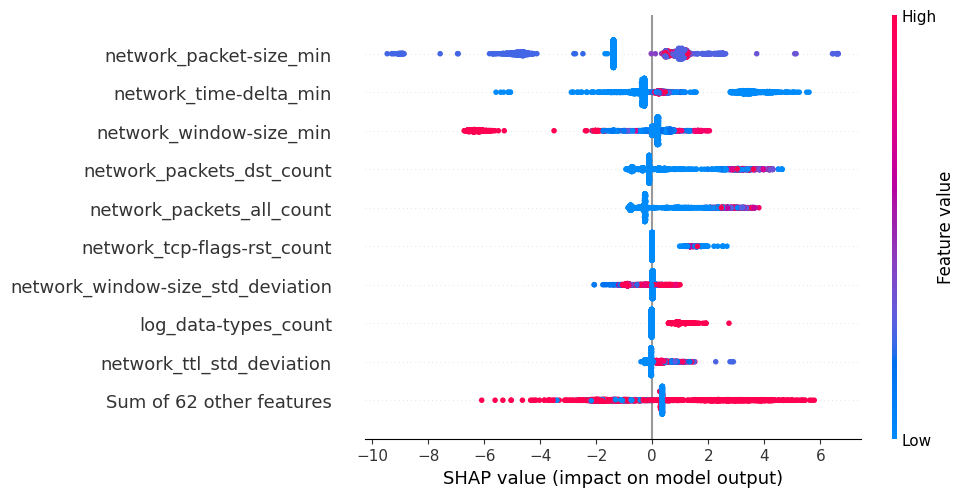


=== Feature Importance (Mean Absolute SHAP) ===
                              feature  importance
34            network_packet-size_min    1.918065
61             network_time-delta_min    1.442884
69            network_window-size_min    1.312663
37          network_packets_dst_count    1.170629
36          network_packets_all_count    0.942822
52        network_tcp-flags-rst_count    0.288002
70  network_window-size_std_deviation    0.247098
4                log_data-types_count    0.225240
66          network_ttl_std_deviation    0.217052
9           network_header-length_avg    0.214302
### Train with Logistic regression


/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Results ===
Confusion matrix:
[[27163   144]
 [ 4903 13229]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     27307
           1       0.99      0.73      0.84     18132

    accuracy                           0.89     45439
   macro avg       0.92      0.86      0.88     45439
weighted avg       0.90      0.89      0.88     45439

Matthews Corrcoef: 0.7783
Average precision: 0.8296
Balanced accuracy: 0.8622
### Train with SVC
=== Linear SVC Results ===
Confusion matrix:
[[27059   248]
 [ 4374 13758]]
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     27307
           1       0.98      0.76      0.86     18132

    accuracy                           0.90     45439
   macro avg       0.92      0.87      0.89     45439
weighted avg       0.91      0.90      0.90     45439

Matthews Corrcoef: 0.7950
Average precisio

/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


=== Local Outlier Factor Results ===
Confusion matrix:
[[19628  7679]
 [ 7375 10757]]
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72     27307
           1       0.58      0.59      0.59     18132

    accuracy                           0.67     45439
   macro avg       0.66      0.66      0.66     45439
weighted avg       0.67      0.67      0.67     45439

Matthews Corrcoef: 0.3112
Average precision: 0.5085
Balanced accuracy: 0.6560
## Attack Type Classification
Label2 mapping: {0: 'benign', 1: 'recon', 2: 'dos', 3: 'ddos', 4: 'mitm', 5: 'web', 6: 'malware', 7: 'bruteforce'}
Number of classes: 8
=== Attack Type Gradient Boosting ===
Confusion matrix:
[[27276    18     0     1     8     0     2     2]
 [ 1507  5205     8     1     9     0     3     2]
 [  189    24  3466    26     1     0     5     1]
 [  354    17    20  3184    27     0     5     0]
 [  129     8     1     7  1425     0     9     0]
 [   81  

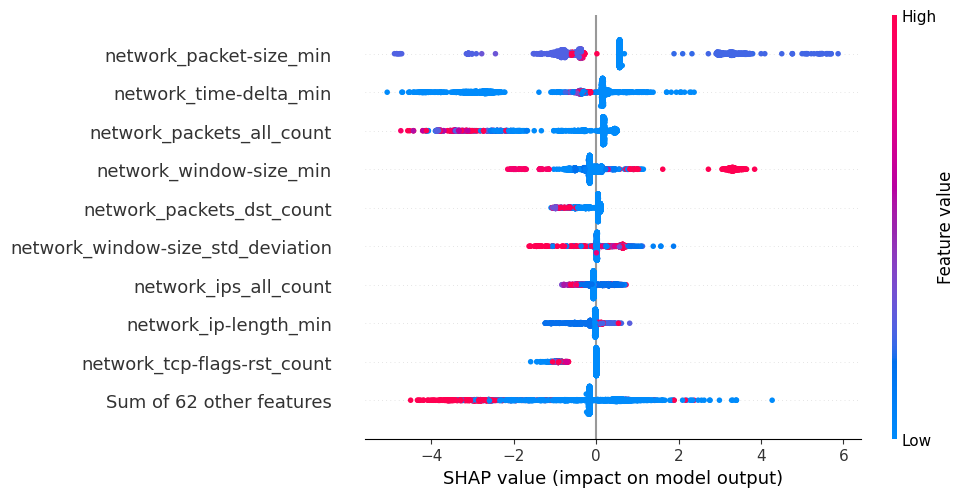


=== Feature Importance (Mean Absolute SHAP) ===
                      feature  importance
61     network_time-delta_min    0.548859
36  network_packets_all_count    0.359733
37  network_packets_dst_count    0.335210
69    network_window-size_min    0.300261
34    network_packet-size_min    0.299148
64            network_ttl_max    0.213197
65            network_ttl_min    0.177738
63            network_ttl_avg    0.168062
13   network_interval-packets    0.166255
59     network_time-delta_avg    0.158482
=== Attack Type Random Forest ===
Confusion matrix:
[[27003   200    21    35    21     3    22     2]
 [ 1550  5154     8     5    10     0     6     2]
 [  188    15  3472    22     7     0     8     0]
 [  365    15    26  3176    22     0     3     0]
 [  154     7     1     7  1398     0    12     0]
 [   80     1     0     0     0   476     0     1]
 [  123    12     1     2     6     0  1465     2]
 [   64     0     1     0     3     0     8   254]]
Classification report:
     

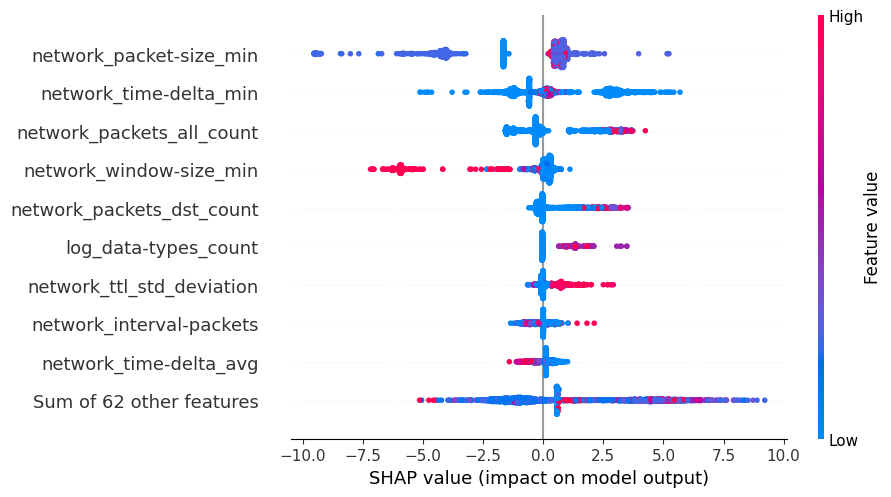


=== Feature Importance (Mean Absolute SHAP) ===
                      feature  importance
34    network_packet-size_min    1.757404
61     network_time-delta_min    1.493839
36  network_packets_all_count    1.312213
69    network_window-size_min    1.196754
37  network_packets_dst_count    0.695573
4        log_data-types_count    0.336977
66  network_ttl_std_deviation    0.321333
13   network_interval-packets    0.310508
59     network_time-delta_avg    0.295901
25     network_macs_all_count    0.277007
### Train with Logistic regression


/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Results ===
Confusion matrix:
[[9041  106]
 [1304 4595]]
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      9147
           1       0.98      0.78      0.87      5899

    accuracy                           0.91     15046
   macro avg       0.93      0.88      0.90     15046
weighted avg       0.91      0.91      0.90     15046

Matthews Corrcoef: 0.8083
Average precision: 0.8480
Balanced accuracy: 0.8837
### Train with SVC
=== Linear SVC Results ===
Confusion matrix:
[[9093   54]
 [1287 4612]]
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      9147
           1       0.99      0.78      0.87      5899

    accuracy                           0.91     15046
   macro avg       0.93      0.89      0.90     15046
weighted avg       0.92      0.91      0.91     15046

Matthews Corrcoef: 0.8190
Average precision: 0.858

/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


=== Local Outlier Factor Results ===
Confusion matrix:
[[6238 2909]
 [2729 3170]]
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      9147
           1       0.52      0.54      0.53      5899

    accuracy                           0.63     15046
   macro avg       0.61      0.61      0.61     15046
weighted avg       0.63      0.63      0.63     15046

Matthews Corrcoef: 0.2182
Average precision: 0.4616
Balanced accuracy: 0.6097
## Attack Type Classification
Label2 mapping: {0: 'benign', 1: 'recon', 2: 'mitm', 3: 'ddos', 4: 'malware', 5: 'bruteforce', 6: 'dos', 7: 'web'}
Number of classes: 8
=== Attack Type Gradient Boosting ===
Confusion matrix:
[[9127   17    0    1    1    0    1    0]
 [ 324 1853    5    4    2    1    0    0]
 [  11    6  499    4    4    0    0    0]
 [  72    9   21 1026    2    0   11    0]
 [  16    4    2    0  515    1    2    0]
 [  16    5    0    0    2  110    1    0]
 [  25    

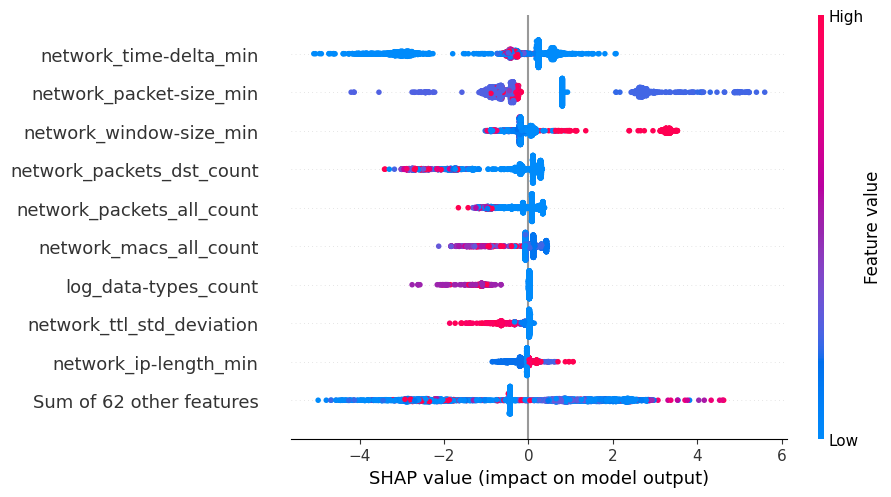


=== Feature Importance (Mean Absolute SHAP) ===
                      feature  importance
61     network_time-delta_min    0.624480
37  network_packets_dst_count    0.571222
64            network_ttl_max    0.349613
63            network_ttl_avg    0.333305
69    network_window-size_min    0.321770
13   network_interval-packets    0.296333
34    network_packet-size_min    0.278160
59     network_time-delta_avg    0.267359
36  network_packets_all_count    0.207367
60     network_time-delta_max    0.197826
=== Attack Type Random Forest ===
Confusion matrix:
[[9018  104    4    9    5    0    7    0]
 [ 351 1827    5    4    1    1    0    0]
 [  22    6  487    5    3    0    1    0]
 [  81    4   17 1015    3    0   21    0]
 [  18    1    3    0  515    1    2    0]
 [  20    1    0    0    0  112    0    1]
 [  29    2    1    4    0    0 1163    0]
 [  21    0    0    0    1    0    0  150]]
Classification report:
              precision    recall  f1-score   support

      benign  

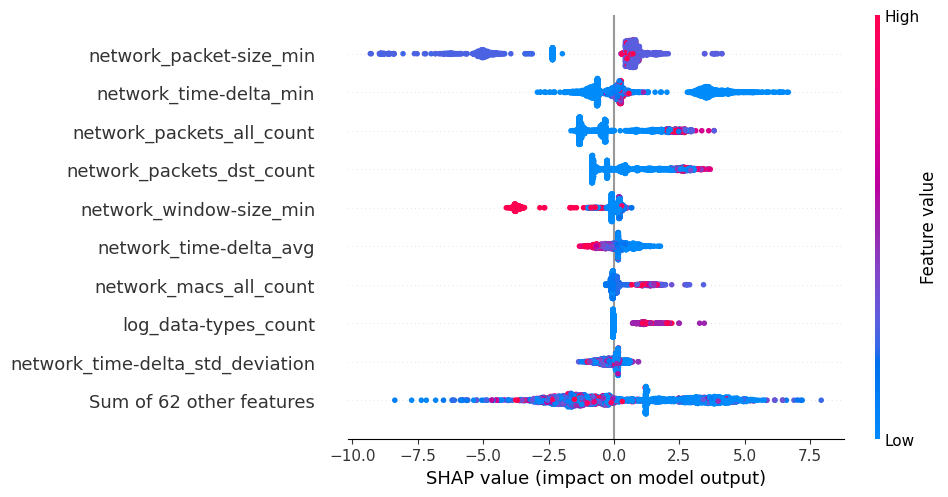


=== Feature Importance (Mean Absolute SHAP) ===
                             feature  importance
34           network_packet-size_min    1.965412
61            network_time-delta_min    1.719629
36         network_packets_all_count    1.237051
37         network_packets_dst_count    1.129838
69           network_window-size_min    0.796027
59            network_time-delta_avg    0.433283
25            network_macs_all_count    0.373631
4               log_data-types_count    0.319263
62  network_time-delta_std_deviation    0.306045
13          network_interval-packets    0.285894
### Train with Logistic regression


/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Results ===
Confusion matrix:
[[5361   50]
 [ 740 2860]]
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      5411
           1       0.98      0.79      0.88      3600

    accuracy                           0.91      9011
   macro avg       0.93      0.89      0.91      9011
weighted avg       0.92      0.91      0.91      9011

Matthews Corrcoef: 0.8225
Average precision: 0.8629
Balanced accuracy: 0.8926
### Train with SVC
=== Linear SVC Results ===
Confusion matrix:
[[5361   50]
 [ 734 2866]]
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      5411
           1       0.98      0.80      0.88      3600

    accuracy                           0.91      9011
   macro avg       0.93      0.89      0.91      9011
weighted avg       0.92      0.91      0.91      9011

Matthews Corrcoef: 0.8238
Average precision: 0.863

/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


=== Local Outlier Factor Results ===
Confusion matrix:
[[3644 1767]
 [1706 1894]]
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      5411
           1       0.52      0.53      0.52      3600

    accuracy                           0.61      9011
   macro avg       0.60      0.60      0.60      9011
weighted avg       0.62      0.61      0.62      9011

Matthews Corrcoef: 0.1990
Average precision: 0.4615
Balanced accuracy: 0.5998
## Attack Type Classification
Label2 mapping: {0: 'benign', 1: 'dos', 2: 'ddos', 3: 'recon', 4: 'mitm', 5: 'malware', 6: 'web', 7: 'bruteforce'}
Number of classes: 8
=== Attack Type Gradient Boosting ===
Confusion matrix:
[[5393    0    2   16    0    0    0    0]
 [  12  723    2    2    1    1    0    1]
 [  35   19  629   11    4    0    0    1]
 [ 122    1    1 1230   10    0    0    0]
 [   8    0    0    0  315    2    0    0]
 [   6    0    2    5    1  266    0    1]
 [  12    

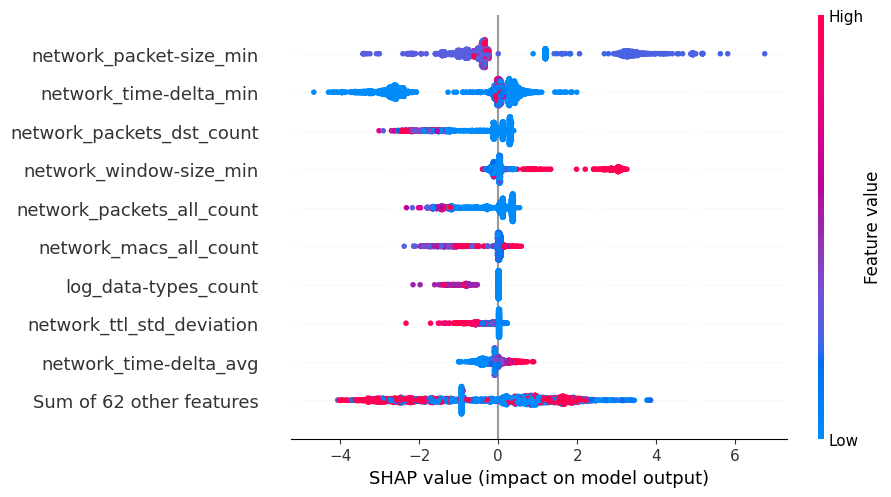


=== Feature Importance (Mean Absolute SHAP) ===
                             feature  importance
61            network_time-delta_min    0.691814
37         network_packets_dst_count    0.434803
63                   network_ttl_avg    0.406641
59            network_time-delta_avg    0.392968
64                   network_ttl_max    0.339154
69           network_window-size_min    0.327057
13          network_interval-packets    0.288857
34           network_packet-size_min    0.271031
62  network_time-delta_std_deviation    0.250388
60            network_time-delta_max    0.238977
=== Attack Type Random Forest ===
Confusion matrix:
[[5327    1    6   72    1    0    0    4]
 [  13  725    2    1    0    1    0    0]
 [  43   16  630    5    4    1    0    0]
 [ 143    0    1 1213    6    0    0    1]
 [  12    0    1    2  309    1    0    0]
 [   9    0    1    4    0  267    0    0]
 [  11    1    0    1    0    1  102    0]
 [  10    0    0    1    0    0    0   62]]
Classification 

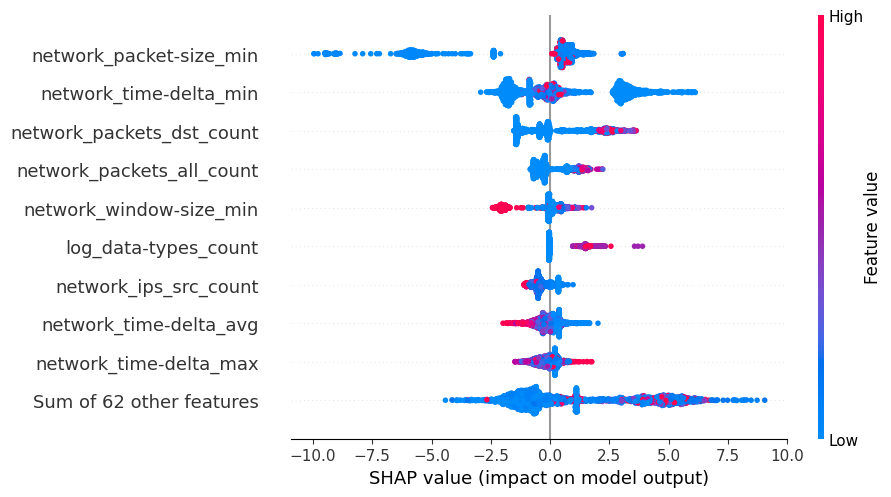


=== Feature Importance (Mean Absolute SHAP) ===
                      feature  importance
34    network_packet-size_min    2.242071
61     network_time-delta_min    1.798221
37  network_packets_dst_count    1.241449
36  network_packets_all_count    0.622451
69    network_window-size_min    0.593661
4        log_data-types_count    0.471246
24      network_ips_src_count    0.459788
59     network_time-delta_avg    0.358935
60     network_time-delta_max    0.335366
25     network_macs_all_count    0.332448
### Train with Logistic regression


/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Results ===
Confusion matrix:
[[3824   58]
 [ 503 1932]]
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3882
           1       0.97      0.79      0.87      2435

    accuracy                           0.91      6317
   macro avg       0.93      0.89      0.90      6317
weighted avg       0.92      0.91      0.91      6317

Matthews Corrcoef: 0.8157
Average precision: 0.8499
Balanced accuracy: 0.8892
### Train with SVC
=== Linear SVC Results ===
Confusion matrix:
[[3830   52]
 [ 514 1921]]
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3882
           1       0.97      0.79      0.87      2435

    accuracy                           0.91      6317
   macro avg       0.93      0.89      0.90      6317
weighted avg       0.92      0.91      0.91      6317

Matthews Corrcoef: 0.8144
Average precision: 0.849

/home/baptiste/cyberml/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


=== Local Outlier Factor Results ===
Confusion matrix:
[[2533 1349]
 [1243 1192]]
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      3882
           1       0.47      0.49      0.48      2435

    accuracy                           0.59      6317
   macro avg       0.57      0.57      0.57      6317
weighted avg       0.59      0.59      0.59      6317

Matthews Corrcoef: 0.1410
Average precision: 0.4264
Balanced accuracy: 0.5710
## Attack Type Classification
Label2 mapping: {0: 'benign', 1: 'malware', 2: 'recon', 3: 'dos', 4: 'web', 5: 'ddos', 6: 'bruteforce', 7: 'mitm'}
Number of classes: 8
=== Attack Type Gradient Boosting ===
Confusion matrix:
[[3868    0   13    0    0    1    0    0]
 [   1  209    5    0    0    0    0    2]
 [  67    1  848    1    0    3    0    0]
 [   7    1    2  448    0    6    0    2]
 [  14    0    0    0   61    0    0    0]
 [  26    0    6   10    0  442    0    7]
 [   2    

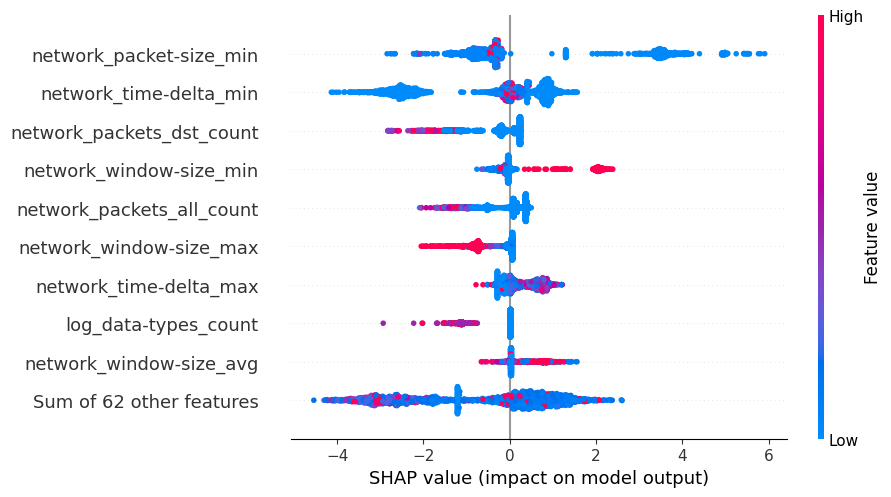


=== Feature Importance (Mean Absolute SHAP) ===
                             feature  importance
61            network_time-delta_min    0.653009
59            network_time-delta_avg    0.400378
63                   network_ttl_avg    0.366718
69           network_window-size_min    0.337669
37         network_packets_dst_count    0.333674
13          network_interval-packets    0.308948
60            network_time-delta_max    0.300885
62  network_time-delta_std_deviation    0.283754
36         network_packets_all_count    0.276083
65                   network_ttl_min    0.272370
=== Attack Type Random Forest ===
Confusion matrix:
[[3839    0   38    0    1    3    0    1]
 [   4  206    2    1    0    0    0    4]
 [  83    2  832    2    0    1    0    0]
 [   9    0    2  447    0    4    0    4]
 [  13    0    0    0   62    0    0    0]
 [  30    2    5   10    0  438    0    6]
 [   3    0    1    0    0    0   43    0]
 [   5    1    2    0    0    0    0  211]]
Classification 

In [9]:
durations = [1, 3, 5, 7]

for duration in durations:
    combined_data = load_and_merge_data(duration)
    X_train, X_test, y_train, y_test, y_type_train, y_type_test, encoded_values = preprocess_data(combined_data)
    
    run_supervised_learning(X_train, X_test, y_train, y_test)
    run_unsupervised_learning(X_train, X_test, y_test, encoded_values)
    run_attack_type_classification(X_train, X_test, y_type_train, y_type_test, encoded_values)